In [1]:
import matplotlib.pyplot as plt
from grav_lens.utils import load_tf_dataset

In [5]:
# el home debe apuntar a la carpeta que contiene la data
# personalmente la tengo en final/
import os
home = os.path.join("..","..")
dataset = load_tf_dataset(data_index=1, max_files=100, home=home)

for X, Y in dataset.take(1):  # Solo mostrar los primeros 5 elementos
    print("X:", X.shape)
    print("Y:", Y.shape)
# quedan cargados a memoria

Using data folder: ..\..\data\1
X: (128, 128, 3)
Y: (128, 128, 1)


X shape: (128, 128, 3)
Y shape: (128, 128, 1)


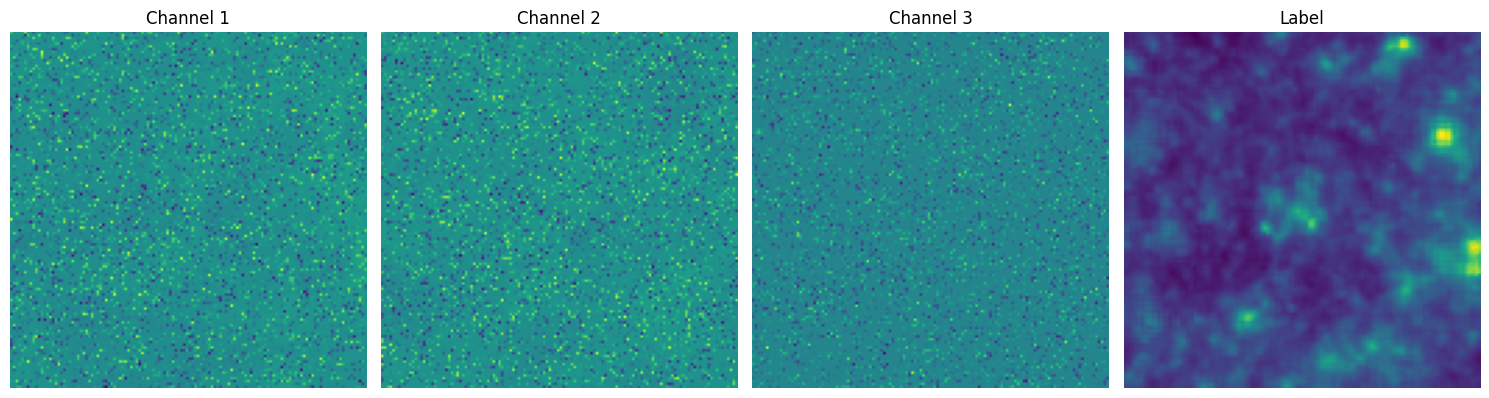

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(15, 5))

# Iterar sobre el dataset y tomar el primer elemento
for X, Y in dataset.take(1):
    # X tiene forma (128, 128, 3) y Y tiene forma (128, 128, 1)
    print("X shape:", X.shape)
    print("Y shape:", Y.shape)

    # Iterar sobre los canales de X
    for idx in range(X.shape[-1]):
        ax[idx].imshow(X[:, :, idx])  # Mostrar el canal individual
        ax[idx].set_title(f'Channel {idx + 1}')  # Título para cada canal
        ax[idx].axis('off')  # Ocultar los ejes para una visualización más limpia

    # Mostrar Y en la última columna
    ax[-1].imshow(Y[:, :, 0])  # Y tiene una sola canal
    ax[-1].set_title('Label')
    ax[-1].axis('off')

plt.tight_layout()
plt.show()


## estudiando la distribucion
Para estudiar la distribucion de los datos, en particular la distribucion de lo que corresponde a la materia oscura

In [7]:
darkm = Y.numpy()
darkm.flatten() # corresponde a la lista de valores

array([-0.04336548, -0.03793335, -0.03573608, ..., -0.03414917,
       -0.03549194, -0.03741455], dtype=float32)

In [9]:
sum(darkm.flatten() < 0)

10784

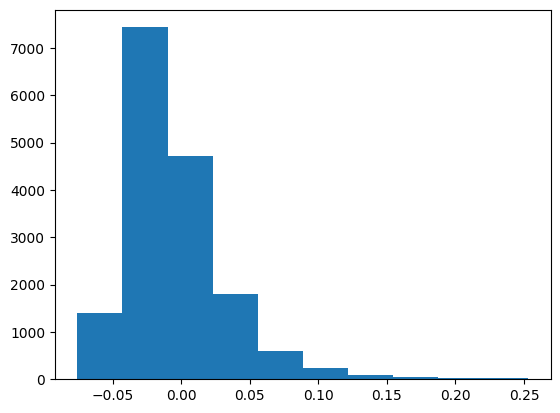

In [10]:
plt.hist(darkm.flatten())
plt.show()

## Encontrar los peaks
Utilizare `5 sigmas` rule

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, label, center_of_mass
from scipy import stats

def get_stats(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    return mean, std_dev

def get_peaks(data, mean, std_dev, sigmas = 5):
    threshold = mean + sigmas * std_dev  # 5 sigma threshold
    peaks = data > threshold
    labeled, num_features = label(peaks)
    peak_indices = center_of_mass(data, labeled, range(1, num_features + 1))
    return peak_indices


In [ ]:
def plot_peaks(data, sigmas=5, ax1=None, ax2=None):
    """
    Grafica los datos de un arreglo con forma (128, 128, 1), destacando los picos que 
    están por encima de un número especificado de desviaciones estándar (sigmas). 
    También muestra la distribución de los valores del arreglo.

    Parámetros:
        data (numpy.ndarray): El arreglo de datos de entrada con forma (128, 128, 1).
        sigmas (int, opcional): El número de desviaciones estándar por encima de la media para considerar un pico. El valor predeterminado es 5.
        ax1 (matplotlib.axes._subplots.AxesSubplot, opcional): El primer eje para la gráfica de la imagen. Si es None, se crearán nuevos ejes.
        ax2 (matplotlib.axes._subplots.AxesSubplot, opcional): El segundo eje para el histograma. Si es None, se crearán nuevos ejes.

    Retorna:
        None: La función muestra la gráfica.
    """

    if data.shape != (128, 128, 1):
        raise ValueError("Input data must have shape (128, 128, 1)")
    
    # Remove the last dimension for plotting purposes
    data = np.squeeze(data, axis=-1)


    if ax1 is None or ax2 is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    mean, std_dev = get_stats(data)
    peak_idx = get_peaks(data, mean, std_dev, sigmas)

    # Plot the data with peaks highlighted on ax1
    im = ax1.imshow(data, origin='lower')
    ax1.set_title('Peaks above {} Sigma'.format(sigmas))
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')

    # Plot the peaks
    for peak in peak_idx:
        y, x = peak
        ax1.plot(x, y, 'rx', markersize=10, markeredgewidth=2)  # Cross marker

        # Draw confidence interval (e.g., 1 sigma circle)
        confidence_interval = plt.Circle((x, y), std_dev, color='r', fill=False, linestyle='--')
        ax1.add_patch(confidence_interval)
    
    # Add a colorbar
    plt.colorbar(im, ax=ax1, label='Density')

    # Plot the distribution of values on ax2
    ax2.hist(data.ravel(), bins=50, color='blue', alpha=0.7)
    ax2.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Mean')
    ax2.axvline(mean + sigmas * std_dev, color='green', linestyle='dashed', linewidth=1, label=f'{sigmas} Sigma')
    ax2.set_title('Distribution of Values')
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Frequency')
    ax2.legend()

    plt.tight_layout()
    plt.show()

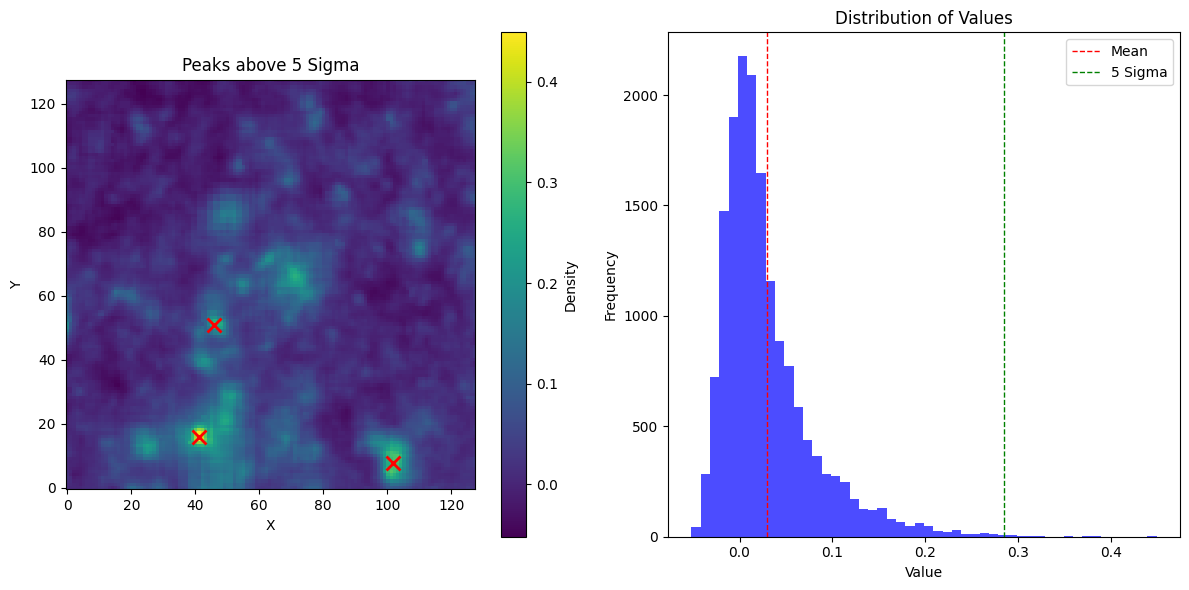

In [ ]:
plot_peaks(Y.numpy(), sigmas=5)